# Check WISE Fluxes in EDGE Database

#### Rebecca Levy
Last Updated: 2021-08-25

Change log:

| Date | Change | Person |
| :- | :- | :- |
| 2021-08-25 | Added comparison to z0MGS tables for EDGE galaxies | RCL |
| 2021-08-19 | compute and plot of W3 offset, | RCL |
| | fixed an error with the AB mag uncertainties in califa_wise.csv, | |
| |  count number of DR3 galaxies with NaN WISE values, | | 
| |  added To Do list | | 
| 2021-08-09 | file created | RCL |

## Goal

The goal of this notebook is to produce robust WISE flux and magnitude measurements for all CALIFA DR3 galaxies (671 galaxies). These fluxes and magnitudes are taken from Table 1 of Bitsakis et al. (2019), though corrections are applied. For the EDGE galaxies, these fluxes are compared to those found in edge_wise.csv, which was compiled by Bitsakis based on an earlier version of the tables published in their 2019 paper. The EDGE galaxies are also compared to the independent results of the z0MGS catalog.

## Summary
1. The uncertaintites on the WISE magnitudes in edge_wise.csv (currently in the database) are wrong. The cause was incorrect error propogation going from flux to magnitudes. This error was corrected in the tables published in Bitsakis et al. (2019).
2. There is an error in the way Bitsakis et al. (2019) converted from Vega to AB magnitudes in their published tables. They used out-of-date zero points and incorrectly applied a correction to the W4 fluxes. This was previously discovered for the W4 data only by Levy et al. (2019; see Section 5.2 and Footnote 13). These mistakes have been corrected for here.
3. There may still be a problem with the W3 magnitudes, as there is a small offset between edge_wise.csv and Bitsakis et al. (2019; Table 1). The other bands agree well between these versions, once the aforementioned corrections are applied.
4. There is excellent agreement with the indepedent z0MGS calculations of the WISE fluxes. The offset in W3 with the corrected Bitsakis values persists here.
5. A new table (califa_wise.csv) is produced. This contains the WISE fluxes, Vega magnitudes, and AB magnitudes (and associated propogated uncertainties) for all of the CALIFA DR3 galaxies (based on the list given in QCflags_std_V500_DR3.csv). This file is sorted by galaxy name. It also contains the CALIFA ID for completeness.

## To Do
 - Round the flux uncertainties in califa_wise.csv to reflect the quantization of the uncertainties in the table from Bitsakis+2019
 - Figure out the source of the W3 offset
 - Which galaxies are outliers between the edge_wise.csv and Bitsakis+2019 tables? Different masking?
 - Check fluxes and magnitudes against the WISE images and apertures themselves (apertues from Catalan-Torrecilla et al. 2015)
 - Compare W4 values to those derived by Catalan-Torrecilla+2015 (the apertures used should be the same as Bitsakis+2019)

In [1]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family']='serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
%matplotlib inline

In [2]:
#import mapping from CALIFA ID to name
id2name = pd.read_csv('QCflags_std_V500_DR3.csv',skiprows=25,usecols=[0,1],names=['ID','Name'])

In [3]:
#open data for EDGE galaxies & get CALIFA IDs
edge_wise = pd.read_csv('edge_wise.csv',skiprows=28)
edge_names = edge_wise['Name'].values.tolist()
edge_idx = np.zeros((len(edge_names),1)).astype('int')
for i in range(len(edge_names)):
    edge_idx[i] = id2name['Name'].values.tolist().index(edge_names[i])
edge_id = id2name['ID'].values[edge_idx]

#The WISE mags are in VEGA magnitudes
#This data is from an old pre-publication version of the Bitsakis et al. tables
edge_W1 = edge_wise['W1'].values
edge_W2 = edge_wise['W2'].values
edge_W3 = edge_wise['W3'].values
edge_W4 = edge_wise['W4'].values
edge_eW1 = edge_wise['eW1'].values
edge_eW2 = edge_wise['eW2'].values
edge_eW3 = edge_wise['eW3'].values
edge_eW4 = edge_wise['eW4'].values
edge_W = np.array([edge_W1,edge_W2,edge_W3,edge_W4]).transpose()
edge_eW = np.array([edge_eW1,edge_eW2,edge_eW3,edge_eW4]).transpose()

In [4]:
#open Bitsakis Table 1 w/ WISE mags
bitsakis = pd.read_csv('Bitsakis_Table1.csv')
bitsakis_id = np.array([bitsakis['CALIFA ID'].map(lambda x: x.lstrip('CALIFA')).values.astype('int')]).squeeze()
#get the indices of the EDGE galaxies in the Bitsakis tables by matching the CALIFA IDs
bitsakis_edgesub_idx = np.zeros((len(edge_names),1)).astype('int')
for i in range(len(edge_id)):
    bitsakis_edgesub_idx[i] = np.where(bitsakis_id==edge_id[i])[0]
    
#The WISE mags are in AB magnitudes
bitsakis_edgesub_W1 = bitsakis['WISE 3.6_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_W2 = bitsakis['WISE 4.5_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_W3 = bitsakis['WISE 12_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_W4 = bitsakis['WISE 22_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_eW1 = bitsakis['e_WISE 3.6_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_eW2 = bitsakis['e_WISE 4.5_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_eW3 = bitsakis['e_WISE 12_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_eW4 = bitsakis['e_WISE 22_mag'].values[bitsakis_edgesub_idx]
bitsakis_edgesub_W = np.squeeze(np.array([bitsakis_edgesub_W1,bitsakis_edgesub_W2,bitsakis_edgesub_W3,bitsakis_edgesub_W4])).transpose()
bitsakis_edgesub_eW = np.squeeze(np.array([bitsakis_edgesub_eW1,bitsakis_edgesub_eW2,bitsakis_edgesub_eW3,bitsakis_edgesub_eW4])).transpose()

## We need to convert the AB magnitudes in the table from Bitsakis et al. (2019) to Vega (or vice versa)

#### But, there is a known problem with how Bitsakis did the conversion from Vega mag (native WISE) to the AB magnitudes they published (Levy et al. 2019, Section 5.2, Footnote 13). So first, we need to "undo" Bitsakis' incorrect conversion.

In [5]:
#Need to convert Bistakis WISE mags from AB to Vega
AB2Vega_J11 = np.array([2.699,3.339,5.174,6.620]) #Jarrett et al. 2011, Table 1

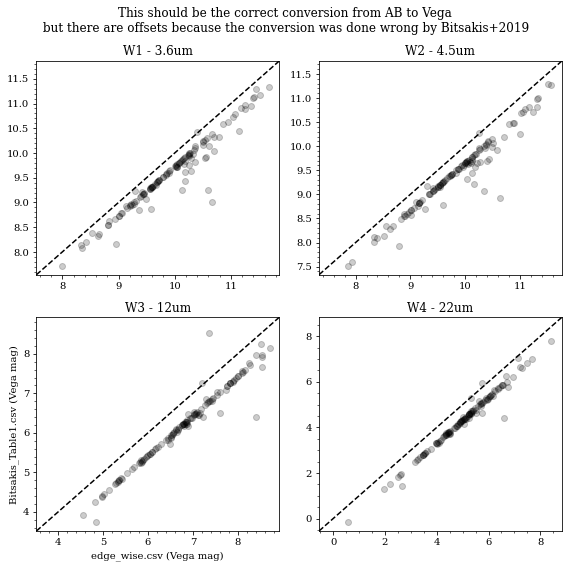

In [6]:
# if we just use this conversion, then you can see the offsets due to the incorrect conversion used by Bitsakis+2019
#compare edge WISE data and corrected Bitsakis WISE data in EDGE galaxies

fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)


titles = ['W1 - 3.6um','W2 - 4.5um','W3 - 12um','W4 - 22um']
for i in range(len(axs)):
    axs[i].plot(edge_W[:,i],bitsakis_edgesub_W[:,i]-AB2Vega_J11[i],'ko',alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_xlabel('edge_wise.csv (Vega mag)')
        axs[i].set_ylabel('Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('This should be the correct conversion from AB to Vega\n but there are offsets because the conversion was done wrong by Bitsakis+2019')
plt.tight_layout()

In [7]:
#But Bitsakis et al. (2019) used old zero-points and incorrectly applied conversions from Vega to AB
#(see Levy et al. 2019, footnote 13)
#so we need to "undo" those first since the WISE catalog is natively in Vega mag
#see also compWISEW4.m by R. Levy, where she worked this out for the W4 band for her 2019 paper
AB2Vega_Y13 = np.array([2.683,3.319,5.242,6.604]) #Yan et al. 2013, used by Bitsakis+2019

#undo their "wrong" conversion from Vega to AB
bitsakis_edgesub_W_corr = bitsakis_edgesub_W - AB2Vega_Y13 + (AB2Vega_J11-AB2Vega_Y13/1.1)

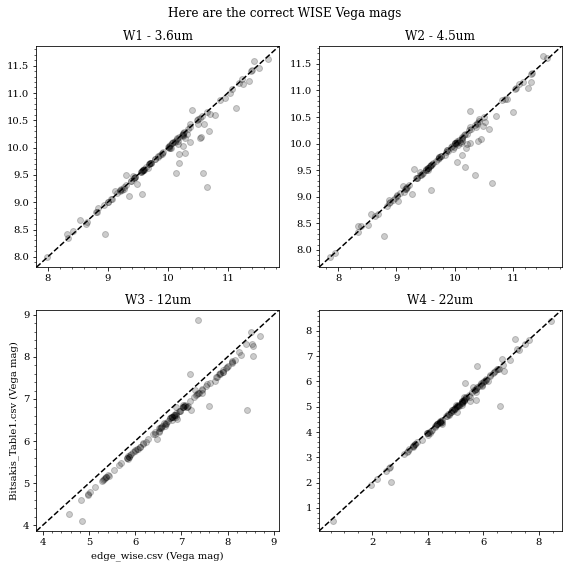

In [8]:
#compare edge WISE data and corrected Bitsakis WISE data in EDGE galaxies

fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)


titles = ['W1 - 3.6um','W2 - 4.5um','W3 - 12um','W4 - 22um']
for i in range(len(axs)):
    axs[i].plot(edge_W[:,i],bitsakis_edgesub_W_corr[:,i],'ko',alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_xlabel('edge_wise.csv (Vega mag)')
        axs[i].set_ylabel('Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('Here are the correct WISE Vega mags')
plt.tight_layout()

There's still an offset for W3

It's also worth noting that the factor of 1.1 ONLY applies to W4 (e.g., https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#red) though it appears that Bitsakis applied is across the board.

Note that because these factors are addative, the uncertaintites presented in Bitsakis et al. 2019 are unaffected by this and are correct.

#### Which galaxies are the outliers? Trends with galaxy property? Differences in masking?

Median W3 offset = 0.23 mag (3.5%)
The median offsets in the other bands are:
 W1 = -0.0019 mag (-0.0%)
 W2 = 0.0013 mag (0.0%)
 W4 = 0.03 mag (0.7%)


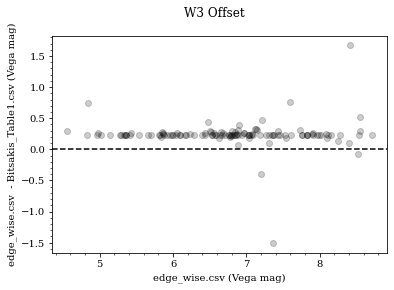

In [9]:
# A closer look at the W3 offset

plt.plot(edge_W[:,2],edge_W[:,2]-bitsakis_edgesub_W_corr[:,2],'ko',alpha=0.2)
plt.axhline(0,color='k',linestyle='--')
plt.minorticks_on()
plt.xlabel('edge_wise.csv (Vega mag)')
plt.ylabel('edge_wise.csv  - Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('W3 Offset')

ave_offset = np.nanmedian(edge_W-bitsakis_edgesub_W_corr,axis=0)
ave_offset_percent = np.nanmedian((edge_W-bitsakis_edgesub_W_corr)/edge_W*100,axis=0)
print('Median W3 offset = %.2f mag (%.1f%%)'
      %(ave_offset[2],ave_offset_percent[2]))

print('The median offsets in the other bands are:\n W1 = %.4f mag (%.1f%%)\n W2 = %.4f mag (%.1f%%)\n W4 = %.2f mag (%.1f%%)'
      %(ave_offset[0],ave_offset_percent[0],ave_offset[1],ave_offset_percent[1],ave_offset[3],ave_offset_percent[3]))

This offset is similar to the W3 residuals shown here: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/figures/sec4_4hf6.gif

## Compare edge_wise.csv & Bitsakis+2019 to z0MGS WISE values

(c.f. Leroy et al. 2019)

Only the EDGE galaxies are in z0MGS, not all of CALIFA

In [10]:
#these are output from the Z0mgs catalog at IPAC in the same order as edge_wise.csv
edge_z0mgs = pd.read_csv('edge_z0mgs.csv')

z0mgs_edgesub_W1_flux = edge_z0mgs['flux_wise1'].values #Jy
z0mgs_edgesub_W2_flux = edge_z0mgs['flux_wise2'].values #Jy
z0mgs_edgesub_W3_flux = edge_z0mgs['flux_wise3'].values #Jy
z0mgs_edgesub_W4_flux = edge_z0mgs['flux_wise4'].values #Jy
z0mgs_edgesub_eW1_flux = edge_z0mgs['std_flux_wise1'].values #Jy
z0mgs_edgesub_eW2_flux = edge_z0mgs['std_flux_wise2'].values #Jy
z0mgs_edgesub_eW3_flux = edge_z0mgs['std_flux_wise3'].values #Jy
z0mgs_edgesub_eW4_flux = edge_z0mgs['std_flux_wise4'].values #Jy


z0mgs_edgesub_W_flux = np.array([z0mgs_edgesub_W1_flux,z0mgs_edgesub_W2_flux,z0mgs_edgesub_W3_flux,z0mgs_edgesub_W4_flux]).transpose()
z0mgs_edgesub_eW_flux = np.array([z0mgs_edgesub_eW1_flux,z0mgs_edgesub_eW2_flux,z0mgs_edgesub_eW3_flux,z0mgs_edgesub_eW4_flux]).transpose()

#convert their fluxes to Vega mags using out conversions
F0 = np.array([309.540,171.787,31.674,8.363]) #Jy, Jarrett et al. 2011, Table 1
z0mgs_edgesub_W = -2.5*np.log10(z0mgs_edgesub_W_flux/F0) #Vega mag


<ipython-input-10-9e466a86e4a3>:19: RuntimeWarning: invalid value encountered in log10
  z0mgs_edgesub_W = -2.5*np.log10(z0mgs_edgesub_W_flux/F0) #Vega mag


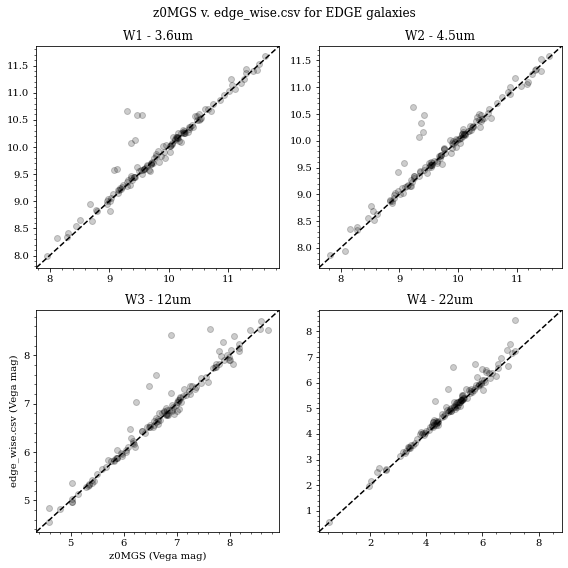

In [ ]:
#compare edge WISE data and corrected Bitsakis WISE data in EDGE galaxies to Z0MGS values

fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)


titles = ['W1 - 3.6um','W2 - 4.5um','W3 - 12um','W4 - 22um']
for i in range(len(axs)):
    axs[i].plot(z0mgs_edgesub_W[:,i],edge_W[:,i],'ko',alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_ylabel('edge_wise.csv (Vega mag)')
        axs[i].set_xlabel('z0MGS (Vega mag)')
plt.suptitle('z0MGS v. edge_wise.csv for EDGE galaxies')
plt.tight_layout()


fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)
for i in range(len(axs)):
    axs[i].plot(z0mgs_edgesub_W[:,i],bitsakis_edgesub_W_corr[:,i],'ko',alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_xlabel('z0MGS (Vega mag)')
        axs[i].set_ylabel('Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('z0MGS v. corrected Bitsakis for EDGE galaxies')
plt.tight_layout()

There is excellent agreement with the z0MGS values!

But the problem with W3 persists in the corrected Bitsakis+2019 values

In [ ]:
# A closer look at the W3 offset w.r.t. z0mgs

plt.plot(z0mgs_edgesub_W[:,2],z0mgs_edgesub_W[:,2]-bitsakis_edgesub_W_corr[:,2],'ko',alpha=0.2)
plt.axhline(0,color='k',linestyle='--')
plt.minorticks_on()
plt.xlabel('edge_z0mgs.csv (Vega mag)')
plt.ylabel('edge_z0mgs.csv  - Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('W3 Offset')

ave_offset = np.nanmedian(z0mgs_edgesub_W-bitsakis_edgesub_W_corr,axis=0)
ave_offset_percent = np.nanmedian((z0mgs_edgesub_W-bitsakis_edgesub_W_corr)/z0mgs_edgesub_W*100,axis=0)
print('Median W3 offset = %.2f mag (%.1f%%)'
      %(ave_offset[2],ave_offset_percent[2]))

print('The median offsets in the other bands are:\n W1 = %.4f mag (%.1f%%)\n W2 = %.4f mag (%.1f%%)\n W4 = %.2f mag (%.1f%%)'
      %(ave_offset[0],ave_offset_percent[0],ave_offset[1],ave_offset_percent[1],ave_offset[3],ave_offset_percent[3]))

## There are also problems with the uncertainties in edge_wise.csv

R. Levy found that the uncertaintites had been improperly calculated (by Bitsakis). To fix them, you have to convert them back to flux (undoing the wrong conversion) and then back to Vega mags properly. She worked this out in compWISEW4.m.

Bitsakis fixed this issue before publishing the values in their 2019 paper. 

In [ ]:
#compare edge WISE data and corrected Bitsakis WISE data in EDGE galaxies
#also plot the uncorrected uncertaintites

fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)


titles = ['W1 - 3.6um','W2 - 4.5um','W3 - 12um','W4 - 22um']
for i in range(len(axs)):
    axs[i].errorbar(edge_W[:,i],bitsakis_edgesub_W_corr[:,i],
                    xerr=edge_eW[:,i],yerr=bitsakis_edgesub_eW[:,i],
                    fmt='ko',alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_xlabel('edge_wise.csv (Vega mag)')
        axs[i].set_ylabel('Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('The uncertaintites in the edge_wise.csv table are wrong.\n Bitsakis didn\'t propogate the uncertainties correctly\n in the early version of their table that became edge_wise.csv.')
plt.tight_layout()

In [ ]:
# fix the uncertaintites on WISE mags in edge_wise.csv
F0 = np.array([309.540,171.787,31.674,8.363]) #Jy, Jarrett et al. 2011, Table 1
edge_W_flux = F0*10**(-edge_W/2.5) #Jy
edge_eW_flux = F0*10**(-edge_eW/2.5) #Jy, this is what Bitsakis did wrong in calculating the uncertaintites that went into edge_wise.csv
#now convert back to Vega mag and propogate the uncertaintites correctly this time
edge_eW_corr = edge_eW_flux*2.5/(edge_W_flux*np.log(10)) #Vega mag

In [ ]:
#compare edge WISE data and corrected Bitsakis WISE data in EDGE galaxies
#also plot the corrected uncertaintites

fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)


titles = ['W1 - 3.6um','W2 - 4.5um','W3 - 12um','W4 - 22um']
for i in range(len(axs)):
    axs[i].errorbar(edge_W[:,i],bitsakis_edgesub_W_corr[:,i],
                    xerr=edge_eW_corr[:,i],yerr=bitsakis_edgesub_eW[:,i],
                    fmt='ko',capsize=3,alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_xlabel('edge_wise.csv (Vega mag)')
        axs[i].set_ylabel('Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('Now the uncertaintites are calculated correctly')
plt.tight_layout()

fig,axs=plt.subplots(2,2)
axs = np.ravel(axs)
fig.set_size_inches(8,8)
titles = ['eW1 - 3.6um','eW2 - 4.5um','eW3 - 12um','eW4 - 22um']
for i in range(len(axs)):
    axs[i].plot(edge_eW_corr[:,i],bitsakis_edgesub_eW[:,i],'ko',alpha=0.2)
    xlim = axs[i].get_xlim()
    ylim = axs[i].get_ylim()
    amin = np.min([xlim[0],ylim[0]])
    amax = np.max([xlim[1],ylim[1]])
    axs[i].plot([amin,amax],[amin,amax],'k--')
    axs[i].set_xlim(amin,amax)
    axs[i].set_ylim(amin,amax)
    axs[i].set_title(titles[i])
    axs[i].minorticks_on()
    if i==2:
        axs[i].set_xlabel('edge_wise.csv (Vega mag)')
        axs[i].set_ylabel('Bitsakis_Table1.csv (Vega mag)')
plt.suptitle('Now the uncertaintites are calculated correctly.\n The uncertainties in Bitsakis+2019 Table 1 are quantized.')
plt.tight_layout()

#### So modulo the offset with W3, things look better now.

## Now we need to calculate the correct WISE mags (Vega & AB) for all CALIFA galaxies

In [ ]:
#grab the indices of the galaxies that are in QCflags_std_V500_DR3.csv
CALIFA_DR3_id = id2name['ID'].values
CALIFA_DR3_names = id2name['Name'].values.tolist()

#set up arrays to hold the magnitudes
CALIFA_DR3_W1_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_W2_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_W3_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_W4_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_eW1_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_eW2_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_eW3_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan
CALIFA_DR3_eW4_uncorr = np.zeros(CALIFA_DR3_id.shape)*np.nan

#get the indices of the Bitsakis galaxies that overlap with DR3 and vice versa
overlapping_ids = list(set(CALIFA_DR3_id) & set(bitsakis_id))
bitsakis_overlap_idx = [list(bitsakis_id).index(x) for x in overlapping_ids]
CALIFA_DR3_overlap_idx = [list(CALIFA_DR3_id).index(x) for x in overlapping_ids]

#count how many galaxies are NaN
non_overlapping_ids = list(set(CALIFA_DR3_id) - set(bitsakis_id))
CALIFA_DR3_nonoverlap_idx = [list(CALIFA_DR3_id).index(x) for x in non_overlapping_ids]
CALIFA_DR3_nonoverlap_names = [CALIFA_DR3_names[int(x)] for x in CALIFA_DR3_nonoverlap_idx]
num_DR3_gal = len(CALIFA_DR3_id)
num_NaN = len(non_overlapping_ids)
print('%g out of the %g DR3 galaxies are not in the Bitsakis+2019 table and will have WISE values of NaN'
      %(num_NaN,num_DR3_gal))
print('These galaxies are %s' %np.sort(CALIFA_DR3_nonoverlap_names))

#grab the WISE mags and uncertaintites for all CALIFA DR3 galaxies
CALIFA_DR3_W1_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['WISE 3.6_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_W2_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['WISE 4.5_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_W3_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['WISE 12_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_W4_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['WISE 22_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_eW1_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['e_WISE 3.6_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_eW2_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['e_WISE 4.5_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_eW3_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['e_WISE 12_mag'].values[bitsakis_overlap_idx]
CALIFA_DR3_eW4_uncorr[CALIFA_DR3_overlap_idx] = bitsakis['e_WISE 22_mag'].values[bitsakis_overlap_idx]

#group
CALIFA_DR3_W_uncorr = np.squeeze(np.array([CALIFA_DR3_W1_uncorr,CALIFA_DR3_W2_uncorr,CALIFA_DR3_W3_uncorr,CALIFA_DR3_W4_uncorr])).transpose()
CALIFA_DR3_eW_uncorr = np.squeeze(np.array([CALIFA_DR3_eW1_uncorr,CALIFA_DR3_eW2_uncorr,CALIFA_DR3_eW3_uncorr,CALIFA_DR3_eW4_uncorr])).transpose()

#undo the "wrong" conversion from Vega to AB
CALIFA_W_Vega = CALIFA_DR3_W_uncorr - AB2Vega_Y13 + (AB2Vega_J11-AB2Vega_Y13/1.1)
CALIFA_eW_Vega = CALIFA_DR3_eW_uncorr.copy()

#convert back to fluxes
CALIFA_W_flux = F0*10**(-CALIFA_W_Vega/2.5) #Jy
CALIFA_eW_flux = CALIFA_W_flux*np.log(10)/2.5*CALIFA_eW_Vega #Jy

#properly account for the W4 correction, which should be applied to the flux measurements, not the magnitudes
# https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#red
CALIFA_W_flux[:,-1] = CALIFA_W_flux[:,-1]*0.90
CALIFA_eW_flux[:,-1] = CALIFA_eW_flux[:,-1]*0.90

#now convert back to Vega mag
CALIFA_W_Vega = -2.5*np.log10(CALIFA_W_flux/F0)
CALIFA_eW_Vega = np.round(CALIFA_eW_flux/CALIFA_W_flux*2.5/np.log(10),2)

#now do the correct conversion back to AB based on the values in Jarrett et al. 2011
CALIFA_W_AB = CALIFA_W_Vega + AB2Vega_J11
CALIFA_eW_AB = CALIFA_eW_Vega.copy()

In [ ]:
#put everything into a dataframe and save as a csv
dict = {'Name' : CALIFA_DR3_names,
       'ID' : CALIFA_DR3_id,
       'W1_Flux_Jy' : CALIFA_W_flux[:,0],
       'e_W1_Flux_Jy' : CALIFA_eW_flux[:,0],
       'W2_Flux_Jy' : CALIFA_W_flux[:,1],
       'e_W2_Flux_Jy' : CALIFA_eW_flux[:,1],
       'W3_Flux_Jy' : CALIFA_W_flux[:,2],
       'e_W3_Flux_Jy' : CALIFA_eW_flux[:,2],
       'W4_Flux_Jy' : CALIFA_W_flux[:,3],
       'e_W4_Flux_Jy' : CALIFA_eW_flux[:,3],
       'W1_Vega_mag' : CALIFA_W_Vega[:,0],
       'e_W1_Vega_mag' : CALIFA_eW_Vega[:,0],
       'W2_Vega_mag' : CALIFA_W_Vega[:,1],
       'e_W2_Vega_mag' : CALIFA_eW_Vega[:,1],
       'W3_Vega_mag' : CALIFA_W_Vega[:,2],
       'e_W3_Vega_mag' : CALIFA_eW_Vega[:,2],
       'W4_Vega_mag' : CALIFA_W_Vega[:,3],
       'e_W4_Vega_mag' : CALIFA_eW_Vega[:,3],
       'W1_AB_mag' : CALIFA_W_AB[:,0],
       'e_W1_AB_mag' : CALIFA_eW_AB[:,0],
       'W2_AB_mag' : CALIFA_W_AB[:,1],
       'e_W2_AB_mag' : CALIFA_eW_AB[:,1],
       'W3_AB_mag' : CALIFA_W_AB[:,2],
       'e_W3_AB_mag' : CALIFA_eW_AB[:,2],
       'W4_AB_mag' : CALIFA_W_AB[:,3],
       'e_W4_AB_mag' : CALIFA_eW_AB[:,3]}
df = pd.DataFrame(dict)

#sort dataframe by galaxy name, not CALIFA ID
df = df.sort_values('Name',ignore_index=True)

#print to csv
df.to_csv('califa_wise.csv',index=False)

In [ ]:
#make a WISE color-color diagnotic plot as an example (e.g., Wright et al. 2010)
#divisions from Jarrett et al. 2017 (Fig 11 right)
plt.rcParams['font.size']=16

plt.figure(figsize=(8,8))
plt.plot(CALIFA_W_Vega[:,1]-CALIFA_W_Vega[:,2],np.squeeze([CALIFA_W_Vega[:,0]-CALIFA_W_Vega[:,1]]),'ko',alpha=0.2)
plt.xlabel('W2-W3 (Vega mag)')
plt.ylabel('W1-W2 (Vega mag)')
plt.minorticks_on()
xlim = plt.xlim()
ylim = plt.ylim()
plt.axhline(0.8,color='orange',linestyle='--')
plt.plot([2,2],[ylim[0],0.8],color='red',linestyle='--')
plt.plot([3.5,3.5],[ylim[0],0.8],color='b',linestyle='--')
plt.text(xlim[0]*0.9,0.8,'AGN & (U)LIRGS',ha='left',va='bottom',color='orange')
plt.text(xlim[0]*0.9,ylim[0]*0.9,'Spheroids',ha='left',va='bottom',color='red')
plt.text(np.mean([2.,3.5]),ylim[0]*0.9,'Int. Disks',ha='center',va='bottom',color='green')
plt.text(xlim[1]*0.99,ylim[0]*0.9,'SF Disks',ha='right',va='bottom',color='blue')
plt.xlim(xlim)
plt.ylim(ylim)